The goal of this notebook is to investigate whether PPI affects microbial exchange in the aerodigestive tract.

Rationale: PPI's inhibit all proton pumps, including those in the lungs. Perhaps PPI use increases exchange between throat or stomach and lungs, because selective environment in lungs is reduced?

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import fisher_exact, spearmanr

%matplotlib inline

In [24]:
fnjsd = '/Users/claire/github/aspiration-analysis/data/analysis/jsd.txt'
fnmeta = '/Users/claire/github/aspiration-analysis/data/clean/rosen.metadata.clean'

jsd = pd.read_csv(fnjsd, sep='\t').dropna(how='all', axis=1)
meta = pd.read_csv(fnmeta, sep='\t', index_col=0)
#jsd.dropna(subset=['Results of worst MBS']).head()

# Exchange
fnexchange = '/Users/claire/github/aspiration-analysis/data/analysis/exchange.txt'
exchange = pd.read_csv(fnexchange, sep='\t')
exchange.head()


,exchange,metadata_col,min_patients,otu,p,patient_type,q,r,site_comparison,shared,diff_exchange
0,0.032787,NaN,3.0,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.800000,all_patients,0.869116,-0.200000,bal_gastric,NaN,NaN
1,0.163934,NaN,3.0,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.001089,all_patients,0.006439,0.675188,bal_gastric,1.0,NaN
2,0.032787,NaN,3.0,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,1.000000,all_patients,1.000000,0.000000,bal_gastric,NaN,NaN
3,0.049180,NaN,3.0,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.396501,all_patients,0.659522,0.428571,bal_gastric,NaN,NaN
4,0.024590,NaN,3.0,k__Bacteria;p__Proteobacteria;c__Alphaproteoba...,0.000000,all_patients,0.000000,1.000000,bal_gastric,NaN,NaN


In [6]:
jsd.columns

Index([u'sample1', u'sample2', u'jsd', u'site1', u'site2', u'site_comparison',
       u'patient_comp', u'subject',
       u'Results of MBS closest to enrollment date', u'Results of worst MBS',
       u'mbs_consolidated', u'ppi_consolidated', u'On PPI currently?',
       u'PPI Status', u'Patient taking PPI', u'Patient taking PPI?',
       u'ACIDSUP', u'Reflux - total number of episodes',
       u'Number of acid reflux episodes',
       u'Total number of reflux episodes (acid+non-acid)', u'SI - Reflux',
       u'SSI - Reflux', u'SAP - Reflux', u'Number of non-acid reflux episodes',
       u'percent distal nonacid', u'percent proximal total',
       u'percent distal acid', u'percent proximal acid',
       u'percent proximal nonacid', u'percent distal total',
       u'number of full colum events/total events',
       u'Number of full column episodes', u'Was Bile CA detected?',
       u'Was Bile DCA detected?', u'Was Bile LCA detected?',
       u'Was Bile TCA detected?'],
      dtype='objec

Great! Looks like I included the PPI metadata directly in the JSD file! Good job, past-Claire.

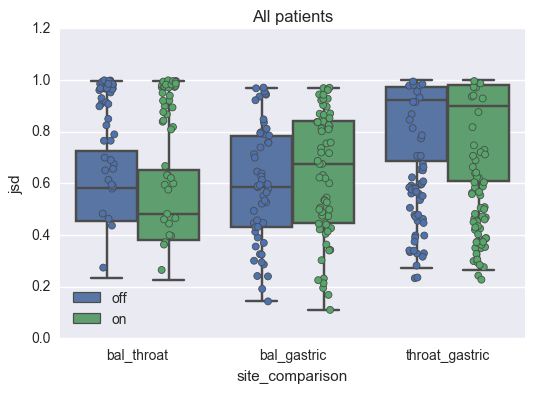

In [67]:
mbscol = 'mbs_consolidated'
ppicol = 'ppi_consolidated'
site_comparisons = ['bal_throat', 'bal_gastric', 'throat_gastric']

toplot = jsd.query('patient_comp == "within"')\
            .query('ppi_consolidated != "conflicting"')\
            .query('site_comparison == @site_comparisons')

sns.boxplot(data=toplot, x='site_comparison', y='jsd', hue=ppicol)
sns.stripplot(data=toplot, x='site_comparison', y='jsd', hue=ppicol,
              jitter=True, split=True, linewidth=0.6,
              order=site_comparisons)
handles, labels = plt.gca().get_legend_handles_labels()
_ = plt.legend(handles[0:len(handles)/2], labels[0:len(handles)/2], loc='lower left')
plt.title("All patients")

In [45]:
from scipy.stats import ranksums

for g, subdf in toplot.groupby('site_comparison'):
    x = subdf.query('ppi_consolidated == "on"')['jsd'].values
    y = subdf.query('ppi_consolidated == "off"')['jsd'].values
    print(g)    
    print(ranksums(x, y))

bal_gastric
RanksumsResult(statistic=1.2319815833372363, pvalue=0.21795596374326165)
bal_throat
RanksumsResult(statistic=-0.43680151060518901, pvalue=0.6622553033887042)
throat_gastric
RanksumsResult(statistic=-1.5652475842498528, pvalue=0.11752486809663916)


### What about throwing aspiration status into the mix?

In [66]:
## Note: plot in cell below this one is the same thing, commenting this out for now
#g = sns.factorplot(data=toplot, col='mbs_consolidated', hue='ppi_consolidated', 
#                   x='site_comparison', y='jsd', kind='violin')

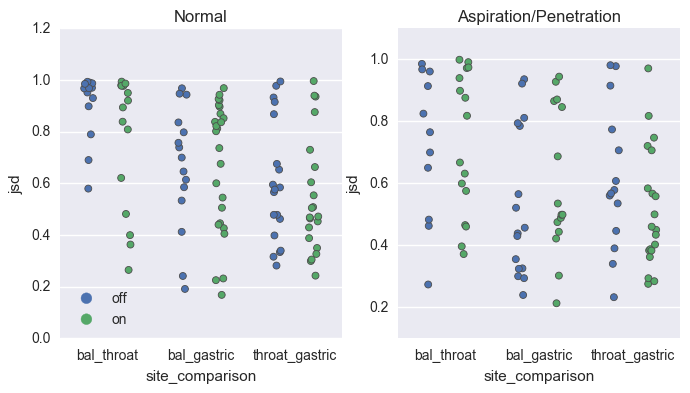

In [64]:
# Boxplot and stripplot are buggy with facet grid and factorplot...

fig, ax = plt.subplots(1, 2, figsize=(8,4))

normal = toplot.query('mbs_consolidated == "Normal"')

#sns.boxplot(data=normal, x='site_comparison', y='jsd', hue=ppicol, ax=ax[0])
sns.stripplot(data=normal, x='site_comparison', y='jsd', hue=ppicol,
              jitter=True, split=True, linewidth=0.6,
              order=site_comparisons, ax=ax[0])
ax[0].set_title("Normal")
handles, labels = ax[0].get_legend_handles_labels()
_ = ax[0].legend(loc='lower left')

asp = toplot.query('mbs_consolidated == "Aspiration/Penetration"')
#sns.boxplot(data=asp, x='site_comparison', y='jsd', hue=ppicol, ax=ax[1])
sns.stripplot(data=asp, x='site_comparison', y='jsd', hue=ppicol,
              jitter=True, split=True, linewidth=0.6,
              order=site_comparisons, ax=ax[1])
ax[1].set_title('Aspiration/Penetration')
ax[1].legend_.remove()


In [56]:
for g, subdf in toplot.groupby(['site_comparison', mbscol]):
    x = subdf.query('ppi_consolidated == "on"')['jsd'].values
    y = subdf.query('ppi_consolidated == "off"')['jsd'].values
    print('{}, {} -- on: {}, off: {}'.format(g[0], g[1], len(x), len(y)))
    print(ranksums(x, y))
    print('')

bal_gastric, Aspiration/Penetration -- on: 15, off: 16
RanksumsResult(statistic=1.0672687103068279, pvalue=0.28585051315425625)

bal_gastric, Normal -- on: 25, off: 15
RanksumsResult(statistic=0.2374663005616566, pvalue=0.81229505982853323)

bal_throat, Aspiration/Penetration -- on: 16, off: 11
RanksumsResult(statistic=0.0, pvalue=1.0)

bal_throat, Normal -- on: 15, off: 14
RanksumsResult(statistic=-1.3529509194631528, pvalue=0.17607131059707104)

throat_gastric, Aspiration/Penetration -- on: 20, off: 14
RanksumsResult(statistic=-1.3997084244475304, pvalue=0.16160065002674062)

throat_gastric, Normal -- on: 21, off: 19
RanksumsResult(statistic=-0.77189300769666935, pvalue=0.44017779903717669)



In [35]:
# Just check that I'm not accidentally plottig duplicate samples or something...
from collections import Counter

for g, subdf in toplot.groupby('site_comparison'):
    print(g)
    print(subdf.groupby('subject').size().values))

bal_gastric
Counter({1: 120})
bal_throat
Counter({1: 92})
throat_gastric
Counter({1: 129, 2: 2})


In [38]:
for g, subdf in toplot.groupby('site_comparison'):
    print(g)
    print(subdf.groupby([mbscol, ppicol]).size())
    print('')

bal_gastric
mbs_consolidated        ppi_consolidated
Aspiration/Penetration  off                 16
                        on                  15
Normal                  off                 15
                        on                  25
dtype: int64

bal_throat
mbs_consolidated        ppi_consolidated
Aspiration/Penetration  off                 11
                        on                  16
Normal                  off                 14
                        on                  15
dtype: int64

throat_gastric
mbs_consolidated        ppi_consolidated
Aspiration/Penetration  off                 14
                        on                  20
Normal                  off                 19
                        on                  21
dtype: int64



# PPI effect on gastric-lung exchange

In [22]:
exchange['patient_type'].unique()


array(['all_patients', 'Aspiration/Penetration', 'Normal', 'on', 'off'], dtype=object)

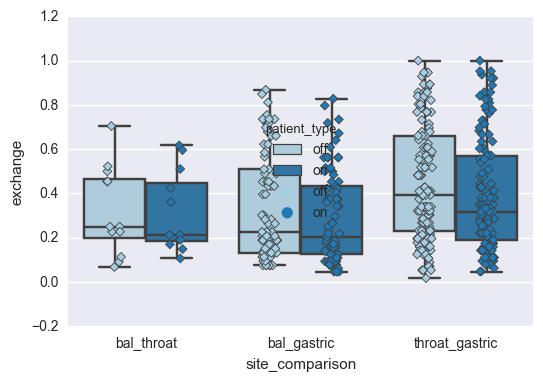

In [26]:
site_comparisons = ['bal_throat', 'bal_gastric', 'throat_gastric']
kwargs = {'palette': 'Paired',
          'hue_order': ['off', 'on']}

exchangetoplot = exchange.query('shared == 1')\
                         .query('patient_type != "all_patients"')

sns.boxplot(x='site_comparison', y='exchange', data=exchangetoplot,
            order=site_comparisons, hue='patient_type',
            fliersize=0, **kwargs)
sns.stripplot(x='site_comparison', y='exchange', data=exchangetoplot,
              order=site_comparisons, hue='patient_type',
              split=True, jitter=True, size=4.5, linewidth=0.6,
              marker='D', **kwargs)

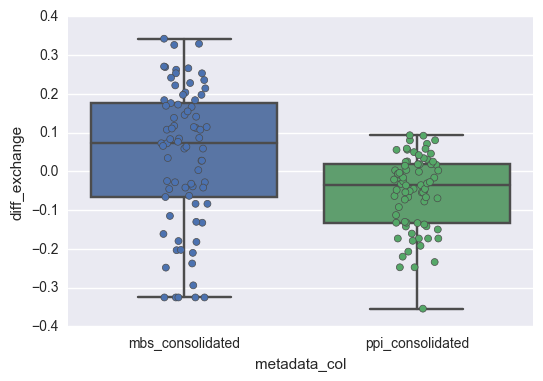

In [45]:
tmp = exchange.query('site_comparison == "bal_gastric"').dropna(subset=['diff_exchange'])[['otu', 'metadata_col', 'diff_exchange']].drop_duplicates()
sns.boxplot(data=tmp, x='metadata_col', y='diff_exchange')
sns.stripplot(data=tmp, x='metadata_col', y='diff_exchange', jitter=True, linewidth=0.5)

In [42]:
from scipy.stats import ttest_rel
tmp = exchange.query('metadata_col == "ppi_consolidated"').query('site_comparison == "bal_gastric"')
tmp = tmp.pivot(index='otu', columns='patient_type', values='exchange')
ttest_rel(tmp['off'], tmp['on'])

Ttest_relResult(statistic=5.9320081039677808, pvalue=3.6709343317207961e-09)

`diff_exchange` was calculated as `on` - `off`, and it looks like the exchange is indeed different for on and off PPI. Interestingly, though, it seems that there's more bal-gastric exchange when patients are *off* PPI...

In [43]:
tmp = exchange.query('metadata_col == "mbs_consolidated"').query('site_comparison == "bal_gastric"')
tmp = tmp.pivot(index='otu', columns='patient_type', values='exchange')
ttest_rel(tmp.iloc[:, 0], tmp.iloc[:, 1])

Ttest_relResult(statistic=3.0578741992680696, pvalue=0.0022666250378556218)